In [1]:
import numpy as np
import xarray as xr
import dask
import warnings

### Preliminaries

In [2]:
###############################
# Set paths
# UPDATE THIS FOR REPRODUCTION
###############################
nex_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/'
cil_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/cil-gdpcir/'
isi_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/isimip3b/regridded/conservative/'
cbp_in = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/carbonplan/'

out_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/results/'
poly_path = '/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/forced_response_polynomial/'

In [3]:
###################
# Models
###################
from utils import nex_ssp_dict, cil_ssp_dict, isimip_ssp_dict, gardsv_ssp_dict, gardsv_var_dict, deepsdbc_dict

nex_models = list(nex_ssp_dict.keys())
cil_models = list(cil_ssp_dict.keys())
isi_models = list(isimip_ssp_dict.keys())
cbp_gard_models = list(gardsv_ssp_dict.keys())
cbp_gard_precip_models = [model for model in cbp_gard_models if 'pr' in gardsv_var_dict[model]]
cbp_deep_models = list(deepsdbc_dict.keys())

In [4]:
#######################
# Land mask (from NEX)
#######################
land_mask = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/metrics/nex-gddp/avg/CanESM5.nc')
land_mask = land_mask.isel(ssp=0, time=0).tas.isnull()
land_mask['lon'] = np.where(land_mask['lon'] > 180, land_mask['lon'] - 360, land_mask['lon'])
land_mask = land_mask.sortby('lon')

In [5]:
############
# Dask
############
from dask_jobqueue import PBSCluster

cluster = PBSCluster(cores=1, memory='50GB', resource_spec='pmem=50GB',
                     # account='open',
                     worker_extra_args=['#PBS -l feature=rhel7'], 
                     walltime='02:00:00')

cluster.scale(jobs=30)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.102.201.237:35213,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Total uncertainty

### Function definition

In [7]:
#######################################################################
# Total uncertainty: variance across all models, scenarios, ensembles 
#######################################################################
def uc_total(nex_in, nex_models, 
             cil_in, cil_models, 
             isi_in, isi_models, 
             cbp_in, cbp_gard_models, cbp_deep_models,
             land_mask,
             metric, submetric,
             year):
    """
    Reads in all models, ssps, and calculates the total uncertainty (variance across
    all model, ssp, ensemble dimensions) for a given year (and possibly DataArray).
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, year, metric, submetric):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = ensemble)
        ds = ds.sel(lat=slice(-60, 90))
        
        # Add model dimension
        if model[-6:] in ['tasmin', 'tasmax']:
            model_str = model[:-7]
        else:
            model_str = model
        ds = ds.assign_coords(model = model_str)
        
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ######################
    # Read all ensembles
    ######################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds_out.append(read_and_process('NEX', nex_in, model, year, metric, submetric))
    ds_nex = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds_out.append(read_and_process('CIL', cil_in, model, year, metric, submetric))
    ds_cil = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds_out.append(read_and_process('ISIMIP', isi_in, model, year, metric, submetric))
    ds_isi = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds_out.append(read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, year, metric, submetric))
    ds_cbp_gard = xr.concat(ds_out, dim='model', fill_value=np.nan)
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds_out.append(read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, year, metric, submetric))
    ds_cbp_deep = xr.concat(ds_out, dim='model', fill_value=np.nan)

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)

    # Mask out ocean points
    ds = xr.where(land_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ## Total uncertainty
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        U_total_true = ds.var(dim=['ensemble', 'ssp', 'model']) # throws warning when all NaNs

    U_total_true = U_total_true.assign_coords(uncertainty = 'total_true')
    
    return U_total_true

## Annual averages

In [10]:
%%time

metric = 'avg'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '.nc')

CPU times: user 58.7 s, sys: 4.14 s, total: 1min 2s
Wall time: 5min 32s


## 1-day maxs

In [11]:
%%time

metric = 'max'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 58.8 s, sys: 3.85 s, total: 1min 2s
Wall time: 5min 31s


## 5-day max (pr)

In [9]:
%%time

metric = 'max5d'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 55.6 s, sys: 3.15 s, total: 58.7 s
Wall time: 5min 15s


## Dry days

In [7]:
%%time

metric = 'dry'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, False,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric +'.nc')

CPU times: user 1min 28s, sys: 8.53 s, total: 1min 37s
Wall time: 10min 48s


## Wet days

In [7]:
%%time
# Wet days: 5yr RP
metric = 'wet'
submetric = ['pr_rp5gmfd_count', 'pr_rp5gmfd_streak']

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, nex_models, 
                                     cil_in, cil_models, 
                                     isi_in, isi_models, 
                                     cbp_in, cbp_gard_precip_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric,
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_rp5gmfd.nc')

CPU times: user 8.75 s, sys: 2.43 s, total: 11.2 s
Wall time: 5min 5s


## Hot days

In [7]:
%%time
# Hot days: 5yr RP GMFD tasmin
metric = 'hot'
submetric = ['tasmin_rp5gmfd_count', 'tasmin_rp5gmfd_streak']
submetric_var = 'tasmin'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                     cil_in, cil_models, 
                                     isi_in, [model + '_' + submetric_var for model in isi_models], 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric, 
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 47.6 s, sys: 3.48 s, total: 51.1 s
Wall time: 5min 25s


In [7]:
%%time
# Hot days: tasmax 5yr GMFD RP
metric = 'hot'
submetric = ['tasmax_rp5gmfd_count', 'tasmax_rp5gmfd_streak']
submetric_var = 'tasmax'

# Dask delayed over years
delayed_res = []
for year in range(2015, 2100):
    # Read all ensembles and compute total uncertainty
    tmp_res = dask.delayed(uc_total)(nex_in, [model + '_' + submetric_var for model in nex_models], 
                                     cil_in, cil_models, 
                                     isi_in, [model + '_' + submetric_var for model in isi_models], 
                                     cbp_in, cbp_gard_models, cbp_deep_models,
                                     land_mask,
                                     metric, submetric, 
                                     year)
    
    # Append
    delayed_res.append(tmp_res)
    
# Compute
res = dask.compute(*delayed_res)

# Merge and store
ds_out = xr.concat(res, dim='time')
ds_out.to_netcdf(out_path + 'total_uncertainty/' + metric + '_' + submetric_var + '_rp5gmfd.nc')

CPU times: user 48.6 s, sys: 3.33 s, total: 51.9 s
Wall time: 5min 58s


In [8]:
ds = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/lafferty-sriver_inprep_tbh_DATA/uc_results/total_uncertainty/hot_tasmax_rp5gmfd.nc')

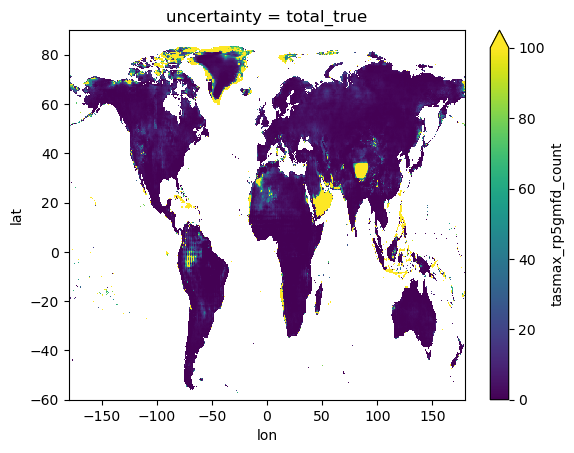

In [11]:
ds.tasmax_rp5gmfd_count.isel(time=10).plot(vmin=0, vmax=100)

# UC without interannual variability

## Functions definitions

In [6]:
def uc_raw(nex_in, nex_models,
           cil_in, cil_models, 
           isi_in, isi_models, 
           cbp_in, cbp_gard_models, cbp_deep_models,
           land_mask,
           metric, submetric, submetric_var,
           year):
    """
    Reads in all models, ssps, and calculates the uncertainty in the 'forced response'
    along each dimension (ssp, model, ens) for a given year (and possibly DataArray).
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, year, metric, submetric, submetric_var):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            if submetric_var:
                ds = xr.open_dataset(path_in + metric + '/' + model + '_' + submetric_var + '.nc')
            else:
                ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sel(time=year)
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = ensemble)
        ds = ds.assign_coords(model = model)
    
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ######################
    # Read all ensembles
    ######################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds_out.append(read_and_process('NEX', nex_in, model, year, metric, submetric, submetric_var))
    ds_nex = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds_out.append(read_and_process('CIL', cil_in, model, year, metric, submetric, submetric_var))
    ds_cil = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds_out.append(read_and_process('ISIMIP', isi_in, model, year, metric, submetric, submetric_var))
    ds_isi = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds_out.append(read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, year, metric, submetric, submetric_var))
    ds_cbp_gard = xr.concat(ds_out, dim='model', fill_value=np.nan)
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds_out.append(read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, year, metric, submetric, submetric_var))
    ds_cbp_deep = xr.concat(ds_out, dim='model', fill_value=np.nan)

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)
    ds = xr.where(land_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ##  Model uncertainty
    # Variance across models, averaged over scenarios and ensembles
    U_model = ds.var(dim='model')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='model').rename('weights') # weights (choose point over land)
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_model = U_model.weighted(weights).mean(dim=['ssp', 'ensemble']) # weighted average

    ## Scenario uncertainty
    # HS09 approach: variance across multi-model means
    U_scen_hs09 = ds.mean(dim=['model', 'ensemble']).var(dim='ssp')
    # BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
    U_scen_bb13 = ds.var(dim='ssp').mean(dim=['model', 'ensemble'])

    ## Downscaling uncertainy
    # Variance across ensembles, averaged over models and scenarios
    U_ens = ds.var(dim='ensemble')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='ensemble').rename('weights') # weights
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_ens = U_ens.weighted(weights).mean(dim=['ssp', 'model'])

    ## Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty = 'scenario_hs09')
    U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty = 'scenario_bb13')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    
    U_out = xr.concat([U_model, U_scen_hs09, U_scen_bb13, U_ens], dim='uncertainty')
    
    if 'member_id' in list(U_out.coords):
        U_out = U_out.isel(member_id=0).drop('member_id')
        
    return U_out

In [12]:
def calculate_raw_uc(metric, submetric, submetric_var, save_str):
    """
    Calculate the uncertainty paritition of the forced response
    for a given selection of parameters/settings
    """
    delayed_res = []
    
    # carbonplan GARD-SV precip models
    if metric in ['wet', 'dry', 'max5d']:
        cbp_gard_models_in = cbp_gard_precip_models
    else:
        cbp_gard_models_in = cbp_gard_models
    
    for year in range(2020, 2095):
        # Read all ensembles and compute UC
        tmp_res = dask.delayed(uc_raw)(nex_in, nex_models, 
                                       cil_in, cil_models, 
                                       isi_in, isi_models, 
                                       cbp_in, cbp_gard_models_in, cbp_deep_models,
                                       land_mask,
                                       metric, submetric, submetric_var,
                                       year)
    
        # Append
        delayed_res.append(tmp_res)
    
    # Compute
    res = dask.compute(*delayed_res)

    # Merge and store
    ds_out = xr.concat(res, dim='time')
    ds_out.to_netcdf(out_path + 'uc_without_iav/' + metric + save_str + '.nc')

## All metrics

In [ ]:
%%time
metric = 'avg'

calculate_raw_uc(metric = metric,
                 submetric = False,
                 submetric_var = False, 
                 save_str = '')

In [9]:
%%time
metric = 'max'

calculate_raw_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    save_str = '')

CPU times: user 1min 48s, sys: 17.4 s, total: 2min 5s
Wall time: 8min 47s


In [10]:
%%time
metric = 'max5d'

calculate_raw_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    save_str = '')

CPU times: user 32.7 s, sys: 3.58 s, total: 36.3 s
Wall time: 2min 43s


In [11]:
%%time
metric = 'dry'

calculate_raw_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    save_str = '')

CPU times: user 1min 53s, sys: 17 s, total: 2min 10s
Wall time: 9min 13s


In [13]:
%%time

metric = 'wet'
submetric = ['pr_q99gmfd_count', 'pr_q99gmfd_streak']

calculate_raw_uc(metric = metric,
                 submetric = submetric,
                 submetric_var = False, 
                 save_str = '_pr_q99gmfd')

CPU times: user 51.5 s, sys: 7.47 s, total: 59 s
Wall time: 4min 14s


In [14]:
%%time

metric = 'wet'
submetric = ['pr_q99era5_count', 'pr_q99era5_streak']

calculate_raw_uc(metric = metric,
                 submetric = submetric,
                 submetric_var = False, 
                 save_str = '_pr_q99gmfd')

CPU times: user 48.1 s, sys: 5.96 s, total: 54.1 s
Wall time: 3min 51s


In [15]:
%%time

metric = 'hot'
submetric = ['tasmax_q99gmfd_count', 'tasmax_q99gmfd_streak']
submetric_var = 'tasmax'

calculate_raw_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = submetric_var, 
                    save_str = 'tasmax_q99gmfd')

CPU times: user 54.1 s, sys: 6.49 s, total: 1min
Wall time: 4min 28s


In [16]:
%%time

metric = 'hot'
submetric = ['tas_q99gmfd_count', 'tas_q99gmfd_streak']
submetric_var = 'tas'

calculate_raw_uc(metric = metric,
                 submetric = submetric,
                 submetric_var = submetric_var, 
                 save_str = 'tas_q99gmfd')

CPU times: user 53 s, sys: 6.56 s, total: 59.6 s
Wall time: 4min 25s


# UC with interannual variability

## Function definitions

### Extracting the (polynomial) forced response

In [6]:
def get_forced_poly(nex_in, nex_models,
                    cil_in, cil_models, 
                    isi_in, isi_models, 
                    cbp_in, cbp_gard_models, cbp_deep_models,
                    land_mask,
                    metric, submetric, submetric_var,
                    poly_path):
    """
    Reads in all models, ssps, and calculates the 'forced response' as a 4th order
    polynomial.
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction to get polynomial for each model/ensemble
    def get_poly_coeffs(ensemble, path_in, model, metric, submetric, submetric_var):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            if submetric_var:
                ds = xr.open_dataset(path_in + metric + '/' + model + '_' + submetric_var + '.nc')
            else:
                ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.sortby('ssp')
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')

        # Forced response via polynomial
        ds = xr.polyval(coord = ds['time'],
                        coeffs = ds.polyfit(dim='time', deg=4)) # 4th order polynomial
        ds = ds.rename({name:name.replace('_polyfit_coefficients', '') for name in list(ds.data_vars)})
            
        # Construct output name: assumes submetrics are of the form ['X_count', 'X_streak']
        out_str = poly_path + metric + '/'

        if submetric:
            submetric_str = submetric[0].replace('_count', '').replace('_streak', '')
            out_str = out_str + submetric_str + '_'
        
        ds.to_netcdf(out_str + ensemble + '_' + model + '.nc')

    #######################
    # Appy to all ensembles
    ######################@
    # Dask delayed
    res = []
    
    # NEX-GDDP 
    for model in nex_models:
        res.append(dask.delayed(get_poly_coeffs)('NEX', nex_in, model, metric, submetric, submetric_var))

    # CIL-GDPCIR
    for model in cil_models:
        res.append(dask.delayed(get_poly_coeffs)('CIL', cil_in, model, metric, submetric, submetric_var))

    # ISIMIP
    for model in isi_models:
        res.append(dask.delayed(get_poly_coeffs)('ISIMIP', isi_in, model, metric, submetric, submetric_var))

    # carbonplan: GARD-SV
    for model in cbp_gard_models:
        res.append(dask.delayed(get_poly_coeffs)('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, metric, submetric, submetric_var))
    
    # carbonplan: DeepSD-BC
    for model in cbp_deep_models:
        res.append(dask.delayed(get_poly_coeffs)('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, metric, submetric, submetric_var))
    
    # Compute
    dask.compute(*res)

### Uncertainty characterization of forced response

In [16]:
def uc_forced(nex_in, nex_models,
              cil_in, cil_models, 
              isi_in, isi_models, 
              cbp_in, cbp_gard_models, cbp_deep_models,
              land_mask,
              metric, submetric, submetric_var,
              year,
              poly, poly_path):
    """
    Reads in all models, ssps, and calculates the uncertainty in the 'forced response'
    along each dimension (ssp, model, ens) for a given year (and possibly DataArray).
    For metrics like 'hot' where there are several sub-metrics based on different 
    thresholds and/or observational data, we need to select a specific DataArray
    to keep the memory manageable.
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, year, metric, submetric, submetric_var, poly):
        # Polynomial responses should have already been calculated
        if poly:
            poly_str = poly_path + metric + '/'
            if submetric:
                submetric_str = submetric[0].replace('_count', '').replace('_streak', '')
                poly_str = poly_str + submetric_str + '_'
            ds = xr.open_dataset(poly_str + ensemble + '_' + model + '.nc')
            ds['time'] = ds.indexes['time'].year
            ds = ds.sel(time=year)
        else:   
            # Read netcdf or zarr
            if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
                if submetric_var:
                    ds = xr.open_dataset(path_in + metric + '/' + model + '_' + submetric_var + '.nc')
                else:
                    ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
            elif ensemble in ['CIL', 'DeepSD-BC']:
                ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds = ds.sel(lat=slice(-60, 90))
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensemble = ensemble)
        ds = ds.assign_coords(model = model)
    
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
            
        # Forced response via running mean if required
        if not poly:
            ds['time'] = ds.indexes['time'].year
            ds = ds.sel(time=slice(year-5, year+5)) # faster rolling mean
            ds = ds.rolling(time=11, center=True).mean().sel(time=year)
    
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
    
        # Return
        return ds

    ######################
    # Read all ensembles
    ######################
    # NEX-GDDP 
    ds_out = []
    for model in nex_models:
        ds_out.append(read_and_process('NEX', nex_in, model, year, metric, submetric, submetric_var, poly))
    ds_nex = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # CIL-GDPCIR
    ds_out = []
    for model in cil_models:
        ds_out.append(read_and_process('CIL', cil_in, model, year, metric, submetric, submetric_var, poly))
    ds_cil = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # ISIMIP
    ds_out = []
    for model in isi_models:
        ds_out.append(read_and_process('ISIMIP', isi_in, model, year, metric, submetric, submetric_var, poly))
    ds_isi = xr.concat(ds_out, dim='model', fill_value=np.nan)

    # carbonplan: GARD-SV
    ds_out = []
    for model in cbp_gard_models:
        ds_out.append(read_and_process('GARD-SV', cbp_in + '/regridded/conservative/GARD-SV/', model, year, metric, submetric, submetric_var, poly))
    ds_cbp_gard = xr.concat(ds_out, dim='model', fill_value=np.nan)
    
    # carbonplan: DeepSD-BC
    ds_out = []
    for model in cbp_deep_models:
        ds_out.append(read_and_process('DeepSD-BC', cbp_in + 'native_grid/DeepSD-BC/', model, year, metric, submetric, submetric_var, poly))
    ds_cbp_deep = xr.concat(ds_out, dim='model', fill_value=np.nan)

    ###########################
    # Merge all and mask ocean
    ###########################
    ds = xr.concat([ds_nex, ds_cil, ds_isi, ds_cbp_gard, ds_cbp_deep],
                       dim='ensemble', fill_value=np.nan)
    ds = xr.where(land_mask, np.nan, ds)
    
    ##########################
    # Uncertainty calculation
    ##########################
    ##  Model uncertainty
    # Variance across models, averaged over scenarios and ensembles
    U_model = ds.var(dim='model')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='model').rename('weights') # weights (choose point over land)
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_model = U_model.weighted(weights).mean(dim=['ssp', 'ensemble']) # weighted average

    ## Scenario uncertainty
    # HS09 approach: variance across multi-model means
    U_scen_hs09 = ds.mean(dim=['model', 'ensemble']).var(dim='ssp')
    # BB13 approach: variance across scenarios, averaged over models and ensembles (no weighting)
    U_scen_bb13 = ds.var(dim='ssp').mean(dim=['model', 'ensemble'])

    ## Downscaling uncertainy
    # Variance across ensembles, averaged over models and scenarios
    U_ens = ds.var(dim='ensemble')
    weights = ds.isel(lat=300, lon=800)[list(ds.data_vars)[0]].count(dim='ensemble').rename('weights') # weights
    weights = xr.where(weights == 1, 0, weights) # remove combinations where variance was calculated over 1 entry
    U_ens = U_ens.weighted(weights).mean(dim=['ssp', 'model'])

    ## Merge and return
    U_model = U_model.assign_coords(uncertainty = 'model')
    U_scen_hs09 = U_scen_hs09.assign_coords(uncertainty = 'scenario_hs09')
    U_scen_bb13 = U_scen_bb13.assign_coords(uncertainty = 'scenario_bb13')
    U_ens = U_ens.assign_coords(uncertainty = 'ensemble')
    
    U_out = xr.concat([U_model, U_scen_hs09, U_scen_bb13, U_ens], dim='uncertainty')
    
    if 'member_id' in list(U_out.coords):
        U_out = U_out.isel(member_id=0).drop('member_id')
        
    return U_out

In [17]:
def calculate_forced_uc(metric, submetric, submetric_var, poly, poly_path, save_str):
    """
    Calculate the uncertainty paritition of the forced response
    for a given selection of parameters/settings
    """
    delayed_res = []
    
    # carbonplan GARD-SV precip models
    if metric in ['wet', 'dry', 'max5d']:
        cbp_gard_models_in = cbp_gard_precip_models
    else:
        cbp_gard_models_in = cbp_gard_models
    
    for year in range(2020, 2095):
        # Read all ensembles and compute UC
        tmp_res = dask.delayed(uc_forced)(nex_in, nex_models, 
                                          cil_in, cil_models, 
                                          isi_in, isi_models, 
                                          cbp_in, cbp_gard_models_in, cbp_deep_models,
                                          land_mask,
                                          metric, submetric, submetric_var,
                                          year,
                                          poly, poly_path)
    
        # Append
        delayed_res.append(tmp_res)
    
    # Compute
    res = dask.compute(*delayed_res)

    # Merge and store
    ds_out = xr.concat(res, dim='time')
    ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + save_str + '.nc')

### Measure of interannual variability

In [9]:
def uc_iav(path_in, ensemble, model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav):
    """
    Calculates the internal variability (variance over all years
    of residuals from rolling mean) for a given model-ssp-ensemble
    """
    # Subfunction for general preprocessing of each model/ensemble
    def read_and_process(ensemble, path_in, model, metric, submetric, submetric_var):
        # Read netcdf or zarr
        if ensemble in ['NEX', 'ISIMIP', 'GARD-SV']:
            if submetric_var:
                ds = xr.open_dataset(path_in + metric + '/' + model + '_' + submetric_var + '.nc')
            else:
                ds = xr.open_dataset(path_in + metric + '/' + model + '.nc')
        elif ensemble in ['CIL', 'DeepSD-BC']:
            ds = xr.open_dataset(path_in + metric + '/' + model, engine='zarr')
            
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds.data_vars):
            ds['pr'] = xr.full_like(ds[list(ds.data_vars)[0]], np.nan)
        
        # Select submetric if chosen
        if submetric:
            ds = ds[submetric]
    
        # Common preprocessing
        ds['time'] = ds.indexes['time'].year
        ds = ds.sortby('ssp')
        ds = ds.assign_coords(ensmod = ensemble + '__' + model)
        ds = ds.sel(lat=slice(-60, 90))
    
        # Fix lon to [-180,180]
        if ds.lon.max() > 180:
            ds['lon'] = np.where(ds['lon'] > 180, ds['lon'] - 360, ds['lon'])
            ds = ds.sortby('lon')
    
        # Return
        return ds

    ###############
    # Read model
    ###############
    ds = read_and_process(ensemble, path_in, model, metric, submetric, submetric_var)
    # Mask out ocean points
    ds = xr.where(land_mask, np.nan, ds)
            
    #####################################
    # Get IAV estimate
    # Variance of residuals
    #####################################
    # Forced response via polynomial or running mean
    if poly:
        poly_str = poly_path + metric + '/'
        if submetric:
            submetric_str = submetric[0].replace('_count', '').replace('_streak', '')
            poly_str = poly_str + submetric_str + '_'
        ds_forced = xr.open_dataset(poly_str + ensemble + '_' + model + '.nc')
        ds_forced['time'] = ds_forced.indexes['time'].year
        
        # Some models/methods are missing precip so fill with NaNs
        if (metric in ['max', 'avg']) and ('pr' not in ds_forced.data_vars):
            ds_forced['pr'] = xr.full_like(ds_forced[list(ds_forced.data_vars)[0]], np.nan)
    else:
        ds_forced = ds.rolling(time=11, center=True).mean().sel(time=slice(2020,2094))
    
    # IAV can be constant value or early/mid/late
    if const_iav:
        iav = (ds - ds_forced).var(dim='time')
    else:
        iav_early = (ds - ds_forced).sel(time=slice(2020,2029)).var(dim='time').assign_coords(time = 'early')
        iav_mid = (ds - ds_forced).sel(time=slice(2050,2059)).var(dim='time').assign_coords(time = 'mid')
        iav_late = (ds - ds_forced).sel(time=slice(2080,2089)).var(dim='time').assign_coords(time = 'late')
        iav = xr.concat([iav_early, iav_mid, iav_late], dim='time')
    
    # Drop member_id and return
    if 'member_id' in list(iav.coords):
        iav = iav.isel(member_id=0).drop('member_id')
    return iav

In [10]:
def make_delayed_list_iav(metric, submetric, submetric_var, poly, poly_path, const_iav):
    """
    Make a delayed list with IAV of all models-ssps-ensembles which 
    can then be combined into one dataset and averaged for best estimate.
    """
    # Parallelize with dask over models
    delayed_res = []
    
    # NEX
    for model in nex_models:
        tmp_res = dask.delayed(uc_iav)(nex_in, 'NEX', model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav)
        delayed_res.append(tmp_res)
        
    # CIL
    for model in cil_models:
        tmp_res = dask.delayed(uc_iav)(cil_in, 'CIL', model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav)
        delayed_res.append(tmp_res)
        
    # ISIMIP
    for model in isi_models:
        tmp_res = dask.delayed(uc_iav)(isi_in, 'ISIMIP', model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav)
        delayed_res.append(tmp_res)
        
    # carbonplan GARD-SV
    if metric in ['wet', 'dry', 'max5d']:
        models = cbp_gard_precip_models
    else:
        models = cbp_gard_models
    for model in models:
        tmp_res = dask.delayed(uc_iav)(cbp_in + '/regridded/conservative/GARD-SV/', 'GARD-SV', model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav)
        delayed_res.append(tmp_res)
        
    # carbonplan DeepSD-BC
    for model in cbp_deep_models:
        tmp_res = dask.delayed(uc_iav)(cbp_in + 'native_grid/DeepSD-BC/', 'DeepSD-BC', model, land_mask, metric, submetric, submetric_var, poly, poly_path, const_iav)
        delayed_res.append(tmp_res)
        
    # return
    return delayed_res

In [11]:
def calculate_iav(metric, submetric, submetric_var, poly, poly_path, const_iav, save_str):
    """
    Calculate the internal variability uncertainty
    for a given selection of parameters/settings
    """
    # Make delayed list
    delayed_res = make_delayed_list_iav(metric = metric, 
                                        submetric = submetric,
                                        submetric_var = submetric_var,
                                        poly = poly, 
                                        poly_path = poly_path,
                                        const_iav = const_iav)
    # Compute
    res = dask.compute(*delayed_res)

    # Merge and average over ensemble + model (ensmod) and ssp
    ds_out = xr.concat(res, dim='ensmod').mean(dim=['ensmod', 'ssp'])
    ds_out.to_netcdf(out_path + 'uc_with_iav/' + metric + '_' + save_str + '.nc')

## Annual averages

In [25]:
%%time

metric = 'avg'

#######################################
# Get the forced response (polynomial)
#######################################
get_forced_poly(nex_in, nex_models,
                cil_in, cil_models, 
                isi_in, isi_models, 
                cbp_in, cbp_gard_models, cbp_deep_models,
                land_mask,
                metric, False, False,
                poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'poly_response')

calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'running_response')

CPU times: user 5min 2s, sys: 32.1 s, total: 5min 34s
Wall time: 23min 5s


## 1-day max

In [26]:
%%time 

metric = 'max'

#######################################
# Get the forced response (polynomial)
#######################################
get_forced_poly(nex_in, nex_models,
                cil_in, cil_models, 
                isi_in, isi_models, 
                cbp_in, cbp_gard_models, cbp_deep_models,
                land_mask,
                metric, False, False,
                poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'poly_response')

calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'running_response')

CPU times: user 10min 6s, sys: 1min 20s, total: 11min 26s
Wall time: 44min 30s


## 5-day max (pr)

In [27]:
metric = 'max5d'

#######################################
# Get the forced response (polynomial)
#######################################
get_forced_poly(nex_in, nex_models,
                cil_in, cil_models, 
                isi_in, isi_models, 
                cbp_in, cbp_gard_precip_models, cbp_deep_models,
                land_mask,
                metric, False, False,
                poly_path)

# ####################################
# # Interannual variability
# ####################################
calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'poly_response')

calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'running_response')

## Dry days

In [28]:
metric = 'dry'

#######################################
# Get the forced response (polynomial)
#######################################
get_forced_poly(nex_in, nex_models,
                cil_in, cil_models, 
                isi_in, isi_models, 
                cbp_in, cbp_gard_precip_models, cbp_deep_models,
                land_mask,
                metric, False, False,
                poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = False,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'poly_response')

calculate_forced_uc(metric = metric,
                    submetric = False,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'running_response')

## Wet days

### q99 GMFD

In [25]:
metric = 'wet'
submetric = ['pr_q99gmfd_count', 'pr_q99gmfd_streak']

#######################################
# Get the forced response (polynomial)
#######################################
get_forced_poly(nex_in, nex_models,
                cil_in, cil_models, 
                isi_in, isi_models, 
                cbp_in, cbp_gard_precip_models, cbp_deep_models,
                land_mask,
                metric, submetric, False,
                poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'pr_q99gmfd_poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = False,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'pr_q99gmfd_poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = False, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'pr_q99gmfd_poly_response')

calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'pr_q99gmfd_running_response')

### q99 ERA5

In [18]:
%%time 

metric = 'wet'
submetric = ['pr_q99era5_count', 'pr_q99era5_streak']

#######################################
# Get the forced response (polynomial)
#######################################
# get_forced_poly(nex_in, nex_models,
#                 cil_in, cil_models, 
#                 isi_in, isi_models, 
#                 cbp_in, cbp_gard_precip_models, cbp_deep_models,
#                 land_mask,
#                 metric, submetric, False,
#                 poly_path)

####################################
# Interannual variability
####################################
# calculate_iav(metric = metric,
#               submetric = submetric,
#               submetric_var = False,
#               poly = True,
#               poly_path = poly_path,
#               const_iav = True,
#               save_str = 'pr_q99era5_poly_response_const_iav')

# calculate_iav(metric = metric,
#               submetric = submetric,
#               submetric_var = False,
#               poly = True,
#               poly_path = poly_path,
#               const_iav = False,
#               save_str = 'pr_q99era5_poly_response_nonconst_iav')

################################
# UC on forced response
################################
# calculate_forced_uc(metric = metric,
#                     submetric = submetric,
#                     submetric_var = False, 
#                     poly = True,
#                     poly_path = poly_path,
#                     save_str = 'pr_q99era5_poly_response')

calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = False, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'pr_q99era5_running_response')

CPU times: user 1min 56s, sys: 9.05 s, total: 2min 5s
Wall time: 9min 43s


## Hot days

### Tasmax GMFD q99

In [41]:
%%time

metric = 'hot'
submetric = ['tasmax_q99gmfd_count', 'tasmax_q99gmfd_streak']
submetric_var = 'tasmax'

#######################################
# Get the forced response (polynomial)
#######################################
# get_forced_poly(nex_in, nex_models,
#                 cil_in, cil_models, 
#                 isi_in, isi_models, 
#                 cbp_in, cbp_gard_models, cbp_deep_models,
#                 land_mask,
#                 metric, submetric, submetric_var,
#                 poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = submetric_var,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'tasmax_q99gmfd_poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = submetric_var,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'tasmax_q99gmfd_poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = submetric_var, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'tasmax_q99gmfd_poly_response')

calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = submetric_var, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'tasmax_q99gmfd_running_response')

CPU times: user 4min 40s, sys: 36.5 s, total: 5min 17s
Wall time: 20min 20s


### Tas GMFD q99

In [12]:
metric = 'hot'
submetric = ['tas_q99gmfd_count', 'tas_q99gmfd_streak']
submetric_var = 'tas'

#######################################
# Get the forced response (polynomial)
#######################################
# get_forced_poly(nex_in, nex_models,
#                 cil_in, cil_models, 
#                 isi_in, isi_models, 
#                 cbp_in, cbp_gard_models, cbp_deep_models,
#                 land_mask,
#                 metric, submetric, submetric_var,
#                 poly_path)

####################################
# Interannual variability
####################################
calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = submetric_var,
              poly = True,
              poly_path = poly_path,
              const_iav = True,
              save_str = 'tas_q99gmfd_poly_response_const_iav')

calculate_iav(metric = metric,
              submetric = submetric,
              submetric_var = submetric_var,
              poly = True,
              poly_path = poly_path,
              const_iav = False,
              save_str = 'tas_q99gmfd_poly_response_nonconst_iav')

################################
# UC on forced response
################################
calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = submetric_var, 
                    poly = True,
                    poly_path = poly_path,
                    save_str = 'tas_q99gmfd_poly_response')

calculate_forced_uc(metric = metric,
                    submetric = submetric,
                    submetric_var = submetric_var, 
                    poly = False,
                    poly_path = poly_path,
                    save_str = 'tas_q99gmfd_running_response')

In [ ]:
client.shutdown()